In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# 07: Simplified tree - Term/interest rate - ALE increase
Exploring the interest rate and term interaction, using a simplified model to help understand the reason for differences.  

Here, I use a custom single, simple tree model to demonstrate a case where the ALE and SHAP curves look similar to the full model curves.  This simplified model was generated by iteratively removing features from the base model, identifying individual trees with the behavior, and then pruning trees (not shown).  This simplified model can help understand why the 2 methods differ.

*This script takes about 3 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path
import sklearn as sk
import matplotlib as mpl
import scipy
import random
import importlib
from matplotlib.ticker import FormatStrFormatter, PercentFormatter
from sklearn.inspection import partial_dependence

In [3]:
from PyALE import ale
import shap

In [4]:
from interactions_package.interactions_package import ip_plot, ip_custom_tree
ip_plot.plot_defaults()

## Import Data

In [5]:
train_samp_df = pd.read_parquet(Path(setup.temp_path) \
                                .joinpath('03_DATA_combined_base_train_samp.parquet')) 

In [6]:
train_samp_df.shape

(100000, 35)

In [7]:
train_df = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_combined_base_train.parquet'))

In [8]:
train_df.shape

(470858, 35)

## Define the tree
The simplified tree has 3 features - annual income, interest rate, and term. I manually define the tree structure, and use it to instantiate an estimator object.  Then, I "fit" the estimator to get the counts of training data reaching each leaf.  This results in a single tree model that can be used by SHAP, ALE, or other methods.temp_clas_simpler.fit(train_df[feature_list])

In [9]:
feature_list = ['annual_inc', 'int_rate', 'term']

In [10]:
cust_tree_dict = {
    'children_left': np.array([ 1, -1,  3,  4,  5, -1, -1,  8, -1, -1, -1]),
    'children_right': np.array([ 2, -1, 10,  7,  6, -1, -1,  9, -1, -1, -1]),
    'feature': np.array([ 2,  1,  0,  0,  1, -2, -2,  1, -2, -2,  1]),
    'threshold': np.array([48,  -2,  40284,  3950, 25.63, -2, -2,  30.9,
        -2, -2,  -2]),
    'n_node_samples': np.zeros(11), # Will be set in fit
    'impurity': np.zeros(11), # Ignored in custom model
    'value': np.array([ 0.02299051,  0.01454258,  0.03233632,  0.06162073, -0.26970194,
        -1.50511424, -0.81047711,  0.06306868,  0.25861977,  1.78682742,
         0.02867946])}

In [11]:
[len(cust_tree_dict[k]) for k in cust_tree_dict.keys()]

[11, 11, 11, 11, 11, 11, 11]

In [12]:
importlib.reload(ip_custom_tree)

<module 'interactions_package.interactions_package.ip_custom_tree' from '/Users/valeriecarey/Documents/projects/2022_12_blog_interactions/code/interactions_package/interactions_package/ip_custom_tree.py'>

In [13]:
tree_estimator = ip_custom_tree.TemplateClassifier(cust_tree_dict)

In [14]:
tree_estimator._get_param_names()

['criterion', 'max_depth', 'tree_dict']

In [15]:
tree_estimator.fit(train_df[feature_list])

TemplateClassifier(max_depth=6,
                   tree_dict={'children_left': array([ 1, -1,  3,  4,  5, -1, -1,  8, -1, -1, -1]),
                              'children_right': array([ 2, -1, 10,  7,  6, -1, -1,  9, -1, -1, -1]),
                              'feature': array([ 2,  1,  0,  0,  1, -2, -2,  1, -2, -2,  1]),
                              'impurity': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
                              'n_node_samples': array([470858, 357527, 113331,  10783,     68,     55,     13,  10715,
        10684,     31, 102548]),
                              'threshold': array([ 4.8000e+01, -2.0000e+00,  4.0284e+04,  3.9500e+03,  2.5630e+01,
       -2.0000e+00, -2.0000e+00,  3.0900e+01, -2.0000e+00, -2.0000e+00,
       -2.0000e+00]),
                              'value': array([ 0.02299051,  0.01454258,  0.03233632,  0.06162073, -0.26970194,
       -1.50511424, -0.81047711,  0.06306868,  0.25861977,  1.78682742,
        0.02867946])})

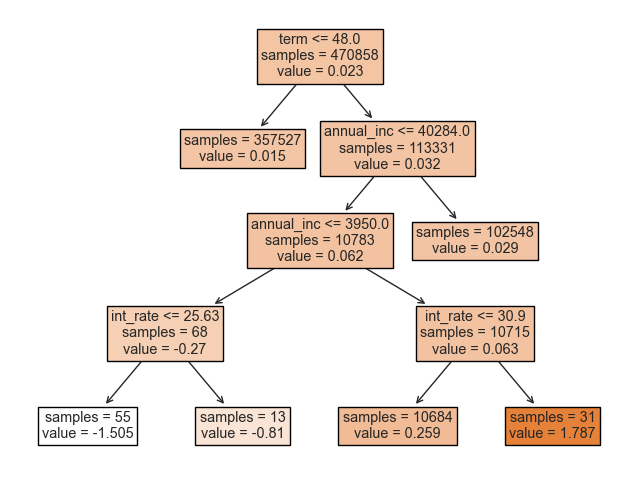

In [16]:
fig, ax = plt.subplots(figsize=(8,6))
_ = sk.tree.plot_tree(tree_estimator, impurity = False, filled=True,
                 feature_names = feature_list, ax=ax)
fig.savefig(Path(setup.temp_path).joinpath('07_PLOT_custom_tree.png'))

## Look at SHAP and ALE interactions for the tree

In [17]:
ale_cust = ale(X=train_samp_df[feature_list], model=tree_estimator, feature=['int_rate', 'term'], plot=False)

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


In [18]:
shap_expl_cust = shap.TreeExplainer(tree_estimator.get_shap_model(), feature_names=feature_list)
shap_int_cust =  shap_expl_cust.shap_interaction_values(train_samp_df[feature_list])
shap_df = pd.concat([train_samp_df[['int_rate', 'term']].reset_index(),
                            pd.DataFrame({'shap': shap_int_cust[:,1, 0]})],
                           axis=1)

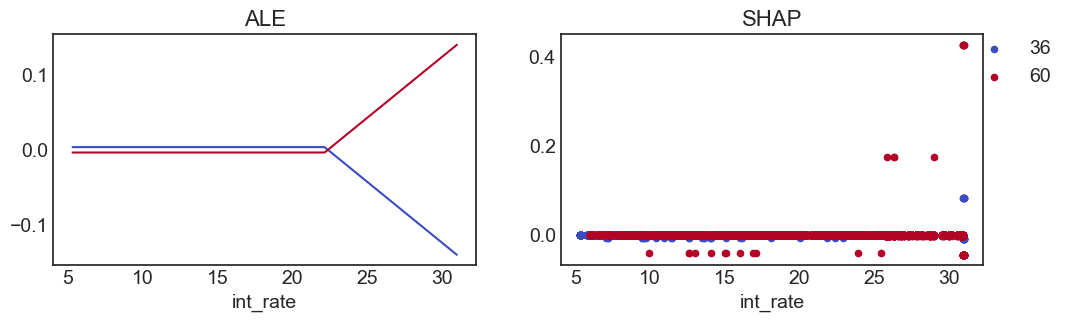

In [19]:
comp_plot = ip_plot.plot_comp_ale_shap(ale_cust, shap_df)
comp_plot.savefig(Path(setup.temp_path).joinpath('07_PLOT_shap_ale_comparison.png'))

This shows the large interaction for ALE, and more ambiguous results for SHAP.  There are some scattered high interaction points.

##### Show the smoothed SHAP plot
Show that the SHAP data doesn't show an overall trend towards high interaction for high term 

In [20]:
shap_df['int_rate_cat'] = pd.cut(shap_df['int_rate'], 20)

In [21]:
shap_agg_df = shap_df.groupby(['int_rate_cat', 'term'])\
    [['shap', 'int_rate']] \
    .agg('mean') \
    .reset_index()

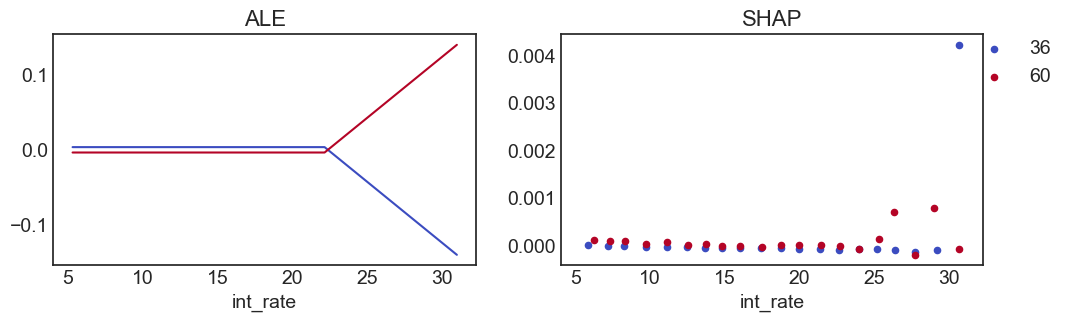

In [22]:
comp_plot_agg =  ip_plot.plot_comp_ale_shap(ale_cust, shap_agg_df)
comp_plot_agg.savefig(Path(setup.temp_path).joinpath('07_PLOT_shap_ale_comparison_agg.png'))